# Topic modelling and sentiment analysis

## Imports 

In [1]:
import re
import spacy
import warnings
import gensim
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from gensim import corpora
from wordcloud import WordCloud, STOPWORDS
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer

warnings.filterwarnings('ignore')

## Data reading 

In [2]:
tweets = pd.read_csv("./clean_tweets.csv")
tweets[:2]

,Unnamed: 0,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place,friends_count,follower_count
0,0,2021-06-18 17:55:49+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Africa is in the midst of a full blown third...,0.166667,0.188889,en,548,0.166667,ketuesriche,551,351,False,[],"[{'screen_name': 'TelGlobalHealth', 'name': 'T...",Mass,0.166667,0.166667
1,1,2021-06-18 17:55:59+00:00,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Dr Moeti is head of WHO in Africa and one of ...,0.133333,0.455556,en,195,0.133333,Grid1949,66,92,False,[],"[{'screen_name': 'globalhlthtwit', 'name': 'An...","Edinburgh, Scotland",0.133333,0.133333


In [3]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6532 entries, 0 to 6531
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          6532 non-null   int64  
 1   created_at          6532 non-null   object 
 2   source              6532 non-null   object 
 3   original_text       6532 non-null   object 
 4   polarity            6532 non-null   float64
 5   subjectivity        6532 non-null   float64
 6   lang                6532 non-null   object 
 7   favorite_count      6532 non-null   int64  
 8   retweet_count       6532 non-null   float64
 9   original_author     6532 non-null   object 
 10  followers_count     6532 non-null   int64  
 11  friends_count       6532 non-null   int64  
 12  possibly_sensitive  3618 non-null   object 
 13  hashtags            6532 non-null   object 
 14  user_mentions       6532 non-null   object 
 15  place               4088 non-null   object 
 16  friend

## Topic modelling

### Data Pre-processing

#### Tokenizing


In [4]:
tweets['clean_text'] = tweets['original_text'].astype(str)
tweets['clean_text'] = tweets['clean_text'].apply(lambda x: x.lower())
tweets['clean_text'] = tweets['clean_text'].apply(
    lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))

In [5]:
custom_stopwords = ['to', 'com']
STOP_WORDS = STOPWORDS.union(custom_stopwords)

In [6]:
sentence_list = []
for w in tweets['clean_text']:
    if w not in STOP_WORDS:
        sentence_list.append(w)

len(sentence_list)

6532

In [7]:
word_list = [sent.split() for sent in sentence_list]

In [8]:
print(word_list[:2])

[['africa', 'is', 'in', 'the', 'midst', 'of', 'a', 'full', 'blown', 'third', 'wave', 'of', 'coronavirus', 'the', 'head', 'of', 'whoafro', 'has', 'warned', 'cases', 'have', 'risen', 'across', 'the', 'continent', 'by', 'more', 'than', 'and', 'deaths', 'have', 'also', 'risen', 'by', 'in', 'the', 'last', 'week', 'jriggers', 'reports', 't', 'co', 'crdhqphfwm'], ['dr', 'moeti', 'is', 'head', 'of', 'who', 'in', 'africa', 'and', 'one', 'of', 'the', 'best', 'public', 'health', 'experts', 'and', 'leaders', 'i', 'know', 'hers', 'is', 'a', 'desperate', 'request', 'for', 'vaccines', 'to', 'africa', 'we', 'plead', 'with', 'germany', 'and', 'the', 'uk', 'to', 'lift', 'patent', 'restrictions', 'and', 'urgently', 'transfer', 'technology', 'to', 'enable', 'production', 'in', 'africa', 't', 'co', 'sogiroihoc']]


### Lemmatization

In [9]:
lemmatizer = WordNetLemmatizer()
word_list_lematized = []

for w in word_list:
    word_list_lematized.append([lemmatizer.lemmatize(x) for x in w])
print(word_list_lematized[:2])

[['africa', 'is', 'in', 'the', 'midst', 'of', 'a', 'full', 'blown', 'third', 'wave', 'of', 'coronavirus', 'the', 'head', 'of', 'whoafro', 'ha', 'warned', 'case', 'have', 'risen', 'across', 'the', 'continent', 'by', 'more', 'than', 'and', 'death', 'have', 'also', 'risen', 'by', 'in', 'the', 'last', 'week', 'jriggers', 'report', 't', 'co', 'crdhqphfwm'], ['dr', 'moeti', 'is', 'head', 'of', 'who', 'in', 'africa', 'and', 'one', 'of', 'the', 'best', 'public', 'health', 'expert', 'and', 'leader', 'i', 'know', 'hers', 'is', 'a', 'desperate', 'request', 'for', 'vaccine', 'to', 'africa', 'we', 'plead', 'with', 'germany', 'and', 'the', 'uk', 'to', 'lift', 'patent', 'restriction', 'and', 'urgently', 'transfer', 'technology', 'to', 'enable', 'production', 'in', 'africa', 't', 'co', 'sogiroihoc']]


### Model

In [12]:
#Create dictionary which contains Id and word
id2word = corpora.Dictionary(word_list_lematized)
corpus = [id2word.doc2bow(tweet) for tweet in word_list]


In [14]:
print(np.array(word_list).shape)
print(np.array(id2word).shape)
print(np.array(corpus).shape)

(6532,)
(9480,)
(6532,)


In [13]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                            id2word=id2word,
                                            num_topics=5,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

In [15]:
pprint(lda_model.show_topics(formatted=False))

[(0,
  [('t', 0.029929504),
   ('covid', 0.029472869),
   ('co', 0.025217908),
   ('the', 0.02126453),
   ('of', 0.017263837),
   ('s', 0.016913123),
   ('to', 0.016860534),
   ('that', 0.016783964),
   ('people', 0.016699117),
   ('amp', 0.01578388)]),
 (1,
  [('dose', 0.054746557),
   ('t', 0.04828759),
   ('co', 0.04691717),
   ('capacity', 0.037861235),
   ('age', 0.03512712),
   ('code', 0.03170683),
   ('pin', 0.031668622),
   ('min', 0.031668287),
   ('limit', 0.031668287),
   ('covaxin', 0.026898751)]),
 (2,
  [('the', 0.049398877),
   ('of', 0.041129146),
   ('in', 0.03488301),
   ('india', 0.032559037),
   ('to', 0.031997316),
   ('and', 0.029348081),
   ('covid', 0.027889078),
   ('africa', 0.027042087),
   ('t', 0.02258303),
   ('co', 0.020294111)]),
 (3,
  [('rt', 0.052820127),
   ('t', 0.050907366),
   ('co', 0.05013768),
   ('just', 0.044834863),
   ('to', 0.043531742),
   ('by', 0.042076856),
   ('you', 0.03825176),
   ('your', 0.037404798),
   ('expired', 0.037124652),

In [16]:
# Compute Perplexity

#It's a measure of how good the model is. The lower the better. Perplexity is a negative value
print('\nPerplexity: ', lda_model.log_perplexity(corpus))
doc_lda = lda_model[corpus]


# Compute Coherence Score
coherence_model_lda = CoherenceModel(
    model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Ldamodel Coherence Score/Accuracy on Tweets: ', coherence_lda)



Perplexity:  -6.261354574593761

 Ldamodel Coherence Score/Accuracy on Tweets:  0.5724396302217729


### Visualization

In [21]:
import pyLDAvis.gensim_models as gensimvis
import pickle
import pyLDAvis

In [23]:
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared

/Users/ea/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.193264 -0.035770       1        1  32.537492
4     -0.103519 -0.059977       2        1  28.011668
0     -0.151483  0.007024       3        1  18.215580
3      0.285981 -0.213884       4        1  11.511844
1      0.162286  0.302608       5        1   9.723417, topic_info=           Term         Freq        Total Category  logprob  loglift
277          rt  1158.000000  1158.000000  Default  30.0000  30.0000
752        dose  1014.000000  1014.000000  Default  29.0000  29.0000
297       india  2017.000000  2017.000000  Default  28.0000  28.0000
211        just  1217.000000  1217.000000  Default  27.0000  27.0000
6            by  1402.000000  1402.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
189          on   112.568280   722.941416   Topic5  -5.1027   0.4709
175     against    82.766688   237.322433   Topic5  -5.4103   1.2772
278           w    69.118272   123.426161   Topic5  -5.5905   1.7508
184  government    71.348216   345.408746   Topic5  -5.5587   0.7535
61      vaccine    73.624169  1025.276592   Topic5  -5.5273  -0.3031

[282 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.492201      a
0         2  0.262414      a
0         3  0.240508      a
0         5  0.005127      a
65        2  0.745311  about
...     ...       ...    ...
93        4  0.407072    you
173       2  0.263015   your
173       4  0.736083   your
431       1  0.993927      z
3371      2  0.994930  zweli

[306 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 4, 2])

##  Sentiment analysis

### Form a new data frame (named `cleanTweet`), containing columns $\textbf{clean-text}$ and $\textbf{polarity}$

In [18]:
cleanTweet = pd.DataFrame(columns=['original_text', 'clean_text', 'lang'])

cleanTweet['original_text'] = tweets['original_text'].to_list()
cleanTweet['lang'] = tweets['lang'].to_list()

In [19]:
def clean_tweet(tweet):
    clean_tweet = re.sub("[^a-zA-Z]",  " ",  tweet)
    return clean_tweet

In [20]:
cleanTweet["clean-text"] = cleanTweet.original_text.apply(clean_tweet)
tweets.drop(['original_text'], axis=1, inplace=True)
cleanTweet


,original_text,clean_text,lang,clean-text
0,Africa is in the midst of a full blown third...,NaN,en,Africa is in the midst of a full blown third...
1,Dr Moeti is head of WHO in Africa and one of ...,NaN,en,Dr Moeti is head of WHO in Africa and one of ...
2,Thank you research note for creating this ama...,NaN,en,Thank you research note for creating this ama...
3,Former Pfizer VP and Virologist Dr Michael Y...,NaN,en,Former Pfizer VP and Virologist Dr Michael Y...
4,I think it s important that we don t sell COVA...,NaN,en,I think it s important that we don t sell COVA...
...,...,...,...,...
6527,RT Givenkazeni Zweli please just release the...,NaN,en,RT Givenkazeni Zweli please just release the...
6528,Former Pfizer VP and Virologist Dr Michael Y...,NaN,en,Former Pfizer VP and Virologist Dr Michael Y...
6529,Jenfeds DcrInYYC Respectfully veterinaria...,NaN,en,Jenfeds DcrInYYC Respectfully veterinaria...
6530,Africa needs millions more doses here amp n...,NaN,en,Africa needs millions more doses here amp n...


In [21]:
print("duplicate count: {}".format(cleanTweet.isnull().sum().sum()))

duplicate count: 6532


### Write a function `text_category` that takes a value `p` and returns, depending on the value of p, a string `'positive'`, `'negative'` or `'neutral'`.

In [22]:
def text_category(p):
  if p > 0:
    return "positive"
  elif p < 0:
    return "negative"
  else:
    return "neutral"

### Apply this function (`text_category`) on the $\textbf{polarity}$ column of `cleanTweet` in 1 above to form a new column called $\textbf{score}$ in `cleanTweet`.

In [23]:
cleanTweet["score"] = tweets["polarity"].apply(text_category)
cleanTweet

,original_text,clean_text,lang,clean-text,score
0,Africa is in the midst of a full blown third...,NaN,en,Africa is in the midst of a full blown third...,positive
1,Dr Moeti is head of WHO in Africa and one of ...,NaN,en,Dr Moeti is head of WHO in Africa and one of ...,positive
2,Thank you research note for creating this ama...,NaN,en,Thank you research note for creating this ama...,positive
3,Former Pfizer VP and Virologist Dr Michael Y...,NaN,en,Former Pfizer VP and Virologist Dr Michael Y...,positive
4,I think it s important that we don t sell COVA...,NaN,en,I think it s important that we don t sell COVA...,positive
...,...,...,...,...,...
6527,RT Givenkazeni Zweli please just release the...,NaN,en,RT Givenkazeni Zweli please just release the...,neutral
6528,Former Pfizer VP and Virologist Dr Michael Y...,NaN,en,Former Pfizer VP and Virologist Dr Michael Y...,positive
6529,Jenfeds DcrInYYC Respectfully veterinaria...,NaN,en,Jenfeds DcrInYYC Respectfully veterinaria...,positive
6530,Africa needs millions more doses here amp n...,NaN,en,Africa needs millions more doses here amp n...,positive


### Visualize The $\textbf{score}$ column using piechart and barchart

In [24]:
category = cleanTweet.groupby(['score']).size()
category

score
negative    1277
neutral     1829
positive    3426
dtype: int64

<AxesSubplot:ylabel='None'>

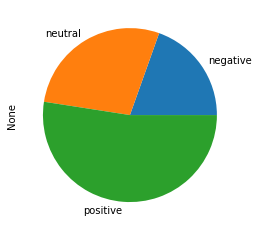

In [25]:
category.plot(kind='pie', y='score')

<AxesSubplot:xlabel='score'>

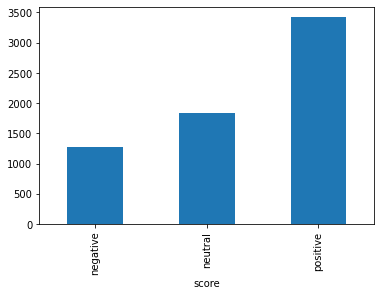

In [26]:
category.plot(kind='bar', y='score')

## build a classification model on the clean tweet.

### Remove rows from `cleanTweet` where $\textbf{polarity}$ $= 0$ (i.e where $\textbf{score}$ = Neutral) and reset the frame index.

In [27]:
cleanTweet = cleanTweet[cleanTweet['score'] != 'neutral']
cleanTweet

,original_text,clean_text,lang,clean-text,score
0,Africa is in the midst of a full blown third...,NaN,en,Africa is in the midst of a full blown third...,positive
1,Dr Moeti is head of WHO in Africa and one of ...,NaN,en,Dr Moeti is head of WHO in Africa and one of ...,positive
2,Thank you research note for creating this ama...,NaN,en,Thank you research note for creating this ama...,positive
3,Former Pfizer VP and Virologist Dr Michael Y...,NaN,en,Former Pfizer VP and Virologist Dr Michael Y...,positive
4,I think it s important that we don t sell COVA...,NaN,en,I think it s important that we don t sell COVA...,positive
...,...,...,...,...,...
6524,Covid vaccines reach the remotest places of ...,NaN,en,Covid vaccines reach the remotest places of ...,negative
6526,Although there is not yet a vaccine for kids t...,NaN,en,Although there is not yet a vaccine for kids t...,positive
6528,Former Pfizer VP and Virologist Dr Michael Y...,NaN,en,Former Pfizer VP and Virologist Dr Michael Y...,positive
6529,Jenfeds DcrInYYC Respectfully veterinaria...,NaN,en,Jenfeds DcrInYYC Respectfully veterinaria...,positive


### Construct a column $\textbf{scoremap}$ Use the mapping {'positive':1, 'negative':0} on the $\textbf{score}$ column

In [28]:
cleanTweet['scoremap'] = cleanTweet["score"].map( lambda score: 1 if score == "positive" else 0)
cleanTweet

,original_text,clean_text,lang,clean-text,score,scoremap
0,Africa is in the midst of a full blown third...,NaN,en,Africa is in the midst of a full blown third...,positive,1
1,Dr Moeti is head of WHO in Africa and one of ...,NaN,en,Dr Moeti is head of WHO in Africa and one of ...,positive,1
2,Thank you research note for creating this ama...,NaN,en,Thank you research note for creating this ama...,positive,1
3,Former Pfizer VP and Virologist Dr Michael Y...,NaN,en,Former Pfizer VP and Virologist Dr Michael Y...,positive,1
4,I think it s important that we don t sell COVA...,NaN,en,I think it s important that we don t sell COVA...,positive,1
...,...,...,...,...,...,...
6524,Covid vaccines reach the remotest places of ...,NaN,en,Covid vaccines reach the remotest places of ...,negative,0
6526,Although there is not yet a vaccine for kids t...,NaN,en,Although there is not yet a vaccine for kids t...,positive,1
6528,Former Pfizer VP and Virologist Dr Michael Y...,NaN,en,Former Pfizer VP and Virologist Dr Michael Y...,positive,1
6529,Jenfeds DcrInYYC Respectfully veterinaria...,NaN,en,Jenfeds DcrInYYC Respectfully veterinaria...,positive,1


### Create feature and target variables `(X,y)` from $\textbf{clean-text}$ and $\textbf{scoremap}$ columns respectively.

In [29]:
(X, y) = cleanTweet['clean-text'], cleanTweet['scoremap']

### Use `train_test_split` function to construct `(X_train, y_train)` and `(X_test, y_test)` from `(X,y)`

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


## Build an `SGDClassifier` model from the vectorize train text data. Use `CountVectorizer()` with a $\textit{trigram}$ parameter and Evaluate your model on the test data.

In [32]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from joblib import dump, load # used for saving and loading sklearn objects
from scipy.sparse import save_npz, load_npz # used for saving and loading sparse matrices
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

In [33]:
trigram_vectorizer = CountVectorizer(ngram_range=(3, 3))
trigram_vectorizer.fit_transform(X)

<4703x25600 sparse matrix of type '<class 'numpy.int64'>'
	with 144963 stored elements in Compressed Sparse Row format>

In [34]:
trigram_vectorizer = CountVectorizer(ngram_range=(1, 3))
trigram_vectorizer.fit_transform(X.values)

X_trigram = trigram_vectorizer.transform(X)


def train_and_show_scores(X, y, title: str) -> None:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, train_size=0.75, stratify=y
    )

    clf = SGDClassifier()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)
    print(f'{title}\nTrain score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}\n')

In [35]:
train_and_show_scores(X_trigram, cleanTweet['scoremap'], title="sentiment")

sentiment
Train score: 1.0 ; Validation score: 0.96

